# Going Deeper CV-4: Augmentation Comparison Study

다음과 같은 Augmentation의 종류에 따른 성능을 비교해보자:
* No Augmentation
* 기본 Augmentation
* Cutmix Augmentation
* Mixup Augmentation


## 라이브러리 불러오기



In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## 데이터 준비

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE57ZFF/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE57ZFF/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


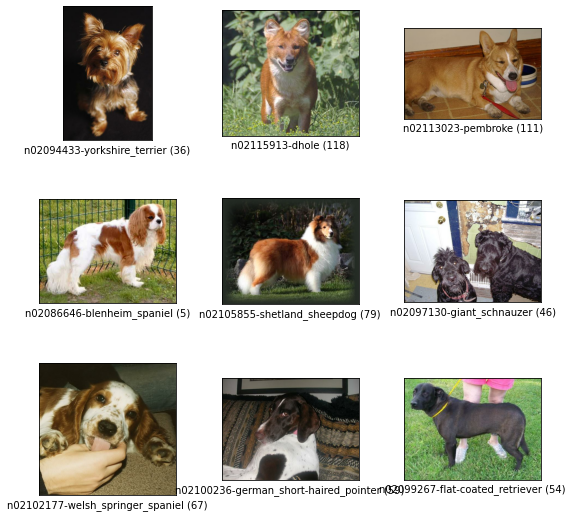

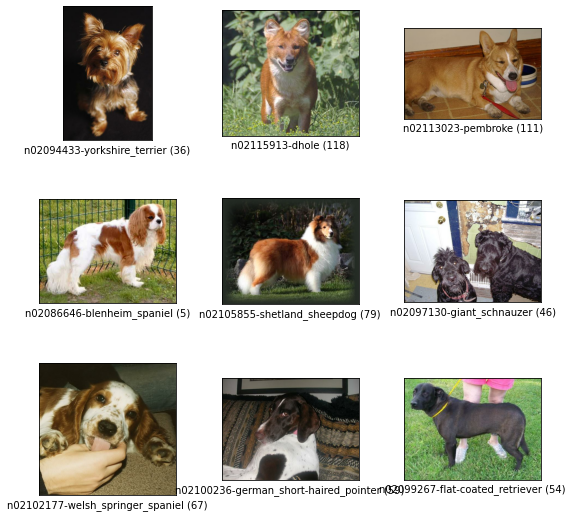

In [3]:
tfds.show_examples(ds_train, ds_info)

## 데이터셋 전처리 준비

In [4]:
# 이미지 정규화
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label



### 기본 Augmentation

In [5]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### Cutmix Augmentation

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


In [7]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_labels(label_a, label_b, image_a, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, image_a, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup Augmentation

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Onehot Encoding

In [12]:
def onehot(image, label, batch_size=16, img_size=224, num_classes=120):
    images = []
    labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
          label_a = tf.one_hot(label_a, num_classes)
        images.append(image_a)
        labels.append(label_a)
    images = tf.reshape(tf.stack(images), (batch_size, img_size, img_size, 3))
    labels = tf.reshape(tf.stack(labels), (batch_size, num_classes))

    return images, labels


### 데이터셋 처리 함수

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


## 데이터셋 전처리

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
# No Augmentation
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
# 기본 Augmentation
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
# 기본 Augmentation + Cutmix
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
# 기본 Augmentation + Mixup
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
# Test Data
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 모델 학습

In [15]:
num_classes = ds_info.features["label"].num_classes

In [16]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

In [17]:
def build_train_model(ds, EPOCH):
    # 모델 생성
    resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
    ])

    # 모델 컴파일
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01),
        metrics=['accuracy'],
    )

    # 모델 훈련
    history = resnet50.fit(
    ds, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    )


    return resnet50, history

### No Augmenation

In [18]:
model_no_aug, history_no_aug = build_train_model(ds_train_no_aug, EPOCH=20)

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 165s 198ms/step - loss: 2.1998 - accuracy: 0.4472 - val_loss: 2.8094 - val_accuracy: 0.2899
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.6790 - accuracy: 0.8149 - val_loss: 1.0227 - val_accuracy: 0.6987
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.1841 - accuracy: 0.9663 - val_loss: 0.9502 - val_accuracy: 0.7225
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0466 - accuracy: 0.9975 - val_loss: 0.9121 - val_accuracy: 0.7406
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0200 - accuracy: 0.9998 - val_loss: 0.9194 - val_accuracy: 0.7402
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9273 - val_accuracy: 0.7425
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.9427 - val_accura

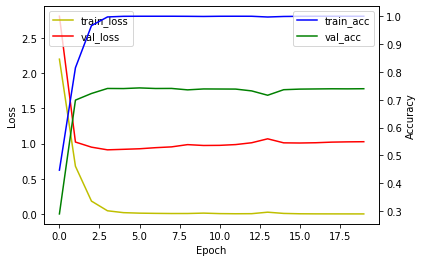

In [19]:
acc_loss_plot(history_no_aug)

### 기본 Augmentation

In [20]:
model_aug, history_aug = build_train_model(ds_train_aug, EPOCH=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 159s 204ms/step - loss: 2.2915 - accuracy: 0.4221 - val_loss: 2.9358 - val_accuracy: 0.2552
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 0.9316 - accuracy: 0.7313 - val_loss: 1.2008 - val_accuracy: 0.6533
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.4857 - accuracy: 0.8675 - val_loss: 1.0102 - val_accuracy: 0.7031
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2404 - accuracy: 0.9433 - val_loss: 1.1692 - val_accuracy: 0.6663
Epoch 5/20
750/750 [==============================] - 167s 223ms/step - loss: 0.1279 - accuracy: 0.9774 - val_loss: 0.9973 - val_accuracy: 0.7277
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0752 - accuracy: 0.9890 - val_loss: 1.0153 - val_accuracy: 0.7245
Epoch 7/20
750/750 [==============================] - 168s 224ms/step - loss: 0.0466 - accuracy: 0.9950 - val_loss: 1.0088 - val_accura

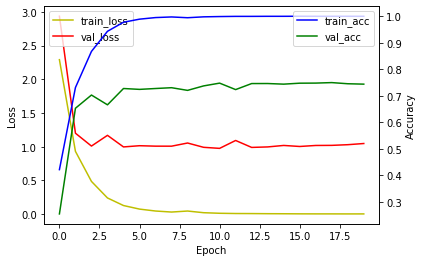

In [21]:
acc_loss_plot(history_aug)

### 기본 Augmentation + Cutmix

In [22]:
model_cutmix, history_cutmix = build_train_model(ds_train_cutmix, EPOCH=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 160s 203ms/step - loss: 3.8782 - accuracy: 0.2066 - val_loss: 3.3917 - val_accuracy: 0.2140
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 3.0341 - accuracy: 0.4048 - val_loss: 1.3445 - val_accuracy: 0.6185
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.7682 - accuracy: 0.4901 - val_loss: 1.3143 - val_accuracy: 0.6427
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5940 - accuracy: 0.5443 - val_loss: 1.1579 - val_accuracy: 0.6732
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 2.4572 - accuracy: 0.5767 - val_loss: 1.3111 - val_accuracy: 0.6358
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.3325 - accuracy: 0.6226 - val_loss: 1.1060 - val_accuracy: 0.6936
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2320 - accuracy: 0.6528 - val_loss: 1.2238 - val_accura

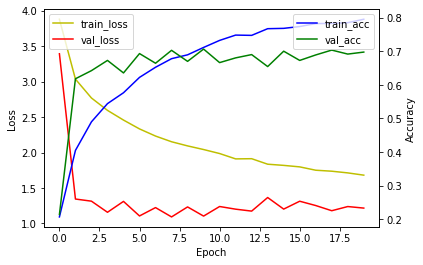

In [23]:
acc_loss_plot(history_cutmix)

### 기본 Augmentation + Mixup

In [24]:
model_mixup, history_mixup = build_train_model(ds_train_mixup, EPOCH=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 162s 207ms/step - loss: 3.7653 - accuracy: 0.2307 - val_loss: 3.4621 - val_accuracy: 0.1897
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9277 - accuracy: 0.4577 - val_loss: 1.4669 - val_accuracy: 0.5868
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6864 - accuracy: 0.5411 - val_loss: 1.6319 - val_accuracy: 0.5561
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.5263 - accuracy: 0.5998 - val_loss: 1.2628 - val_accuracy: 0.6444
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 2.4192 - accuracy: 0.6395 - val_loss: 1.3131 - val_accuracy: 0.6360
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2918 - accuracy: 0.6823 - val_loss: 1.3246 - val_accuracy: 0.6349
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2583 - accuracy: 0.7005 - val_loss: 1.2834 - val_accura

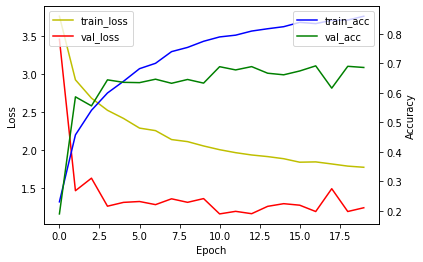

In [25]:
acc_loss_plot(history_mixup)

## 모델 성능 비교

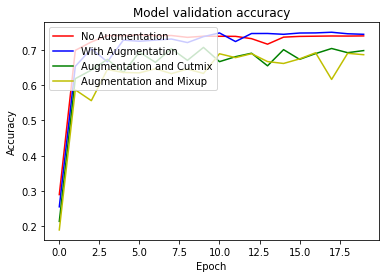

In [26]:
plt.plot(history_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix.history['val_accuracy'], 'g')
plt.plot(history_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Augmentation and Cutmix', 'Augmentation and Mixup'], loc='upper left')
plt.show()

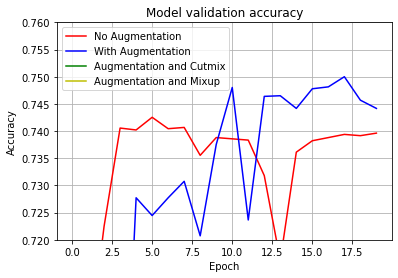

In [27]:
plt.plot(history_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix.history['val_accuracy'], 'g')
plt.plot(history_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Augmentation and Cutmix', 'Augmentation and Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

# 회고

* 의외로 augmentation을 진행한 모델의 성능이 augmentation을 진행하지 않은 모델보다 그리 높지 않다. Epoch의 수가 부족해서일까?
* 아니면 시행한 augmentation의 종류가 적어서일 수도 있다. 추가적인 실험이 필요해보인다.
* Cutmix와 Mixup을 이번 노드를 통해 처음 접하게 되었는데, 이게 성능을 높이기는 하는지를 잘 모르겠다. 현재 20 Epoch를 돌려봤을 때만 놓고 보면 성능이 오히려 더 떨어지는데, 이것이 더 오래동안 훈련을 시키면 성능이 개선될지 궁금하다. 
* 이번 노드를 통해 이미지에 직접 작업을 하여 cutmix/mixup과 같은 변형을 구현할 수 있었다. 이런 식으로 이미지를 직접 다루는 연습이 필요한데 마침 잘 됐다. 